28th Annual Computational Neuroscience Meeting (CNS\*2019), July 13-17, 2019.   
University of Barcelona, Barcelona, Spain.


# Tutorial: Model-based analysis of brain connectivity from neuroimaging data
### Session 4: Network analysis. Dynamic communicability and flow
#### Gorka Zamora-López, Ph.D.

<img src="Images/UPFlogo_smaller.png" style="float:right; width:149px; height:50px"  alt="UPF logo" />
<img src="Images/HBPlogo_smaller.png" style="float:left; width:254px; heigth:50px " alt="HBP logo" />

<br/>
<br/>
<br/>

----------
#### Dependencies

This tutorial requires a Python 3.X installation together with NumPy and Matplotlib libraries. It also requires further in-house modules. [GAlib](https://github.com/gorkazl/pyGAlib) is a generic library for graph analysis; and [NetDynFlow](https://github.com/gorkazl/NetDynFlow) to estimate and study dynamic communicability and flow, and to perform the model-based temporal network analysis.

#### Outline
1. DynComFlow library installation and overview
2. First concepts. Path graphs
3. Common graphs: random, ring-lattice, scale-free
4. Application to neuroimage data


### Import the main libraries

To get started, the first thing we need is to load the libraries we will need to work.

In [1]:
from __future__ import division, print_function

from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg

**Import further dependencies**

The following cells will check whether *GAlib* and *NetDynFlow* are already installed in the current working environment, otherwise, it will call `pip` for the installation (a working internet connection is required). **NOTE**: The exclamation mark ( ! ) before ``pip install galib`` indicates to the Jupyter Notebook that the current line is a system command, which is then treated as if it were run from a terminal.

In [2]:
## Check if GAlib is installed in the current environment, otherwise install
try:
    import galib
except:
    # Install from PyPI
    print('Installing GAlib...')
    ! pip install galib
    import galib

In [3]:
import galib.models
import galib.tools

In [4]:
galib?
# galib.metrics?
# galib.models?
# galib.tools?

In [5]:
## Check if NetDynFlow is installed in the current environment, otherwise install
try:
    import netdynflow as ndf
except:
    # Install from the GitHub repository
    print('Installing NetDynFlow...')
    ! pip install git+https://github.com/gorkazl/NetDynFlow.git@master
    import netdynflow as ndf

In [6]:
ndf?
# ndf.core?
# ndf.metrics?

<br>

## PART 1: First concepts. Dynamic communicability and flow

General summary on dynamic communicability and flow. See the presentation. For reference and citation, see:

- M. Gilson, N.E. Kouvaris et al "*[Framework based on communicability and flow to analyze complex network dynamics](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.052301)*" Phys. Rev. E 97, 052301 (2018).
- M. Gilson, N.E. Kouvaris et al "*[Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability](https://www.sciencedirect.com/science/article/pii/S1053811919305889?via%3Dihub)*" *in press* NeuroImage (2019).



### 1.1) Example-1: Path graphs

#### Dynamic flow
We start by studying the flow and dynamic communicability on very simple graphs in order to understand the basic concepts. As a simple example we consider chain graphs as the one with directed arcs as in the figure below. We characterise how the perturbation applied to the first node propagates along the chain.

<img src="Images/PathGraph_Directed1.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

First, we create the network and estimate its spectral radius in order to identify the largest time-constant τ we can apply to the leakage term so that the network dynamics are convergent.

In [7]:
# Create a directed path graph of N = 6 nodes
N = 6
dirnet = galib.models.PathGraph(N, directed=True)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(dirnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:', evmax )
print( 'Largest possible tau:', maxtau)

Spectral radius: 0.0
Largest possible tau: inf


/anaconda3/envs/neural_datascience/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


To cause a flow we need to _**set an external perturbation**_. Therefore, the matrix `sigma` is defined, which encodes the covariances between the external Gaussian noisy inputs. Since here we only want to excite the first node, `sigma` will be all zeros exept for its `[0,0]` element.

In [8]:
# Set the matrix of noisy inputs
sigma = zeros((N,N), np.float)
sigma[0,0] = 1.0

# Set a time-constant
tau = 1.0

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
fullflow_dir = ndf.FullFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, scalenorm=True)
dynflow_dir = ndf.DynFlow(dirnet, tau, sigma, tmax=tfinal, timestep=dt, scalenorm=True)

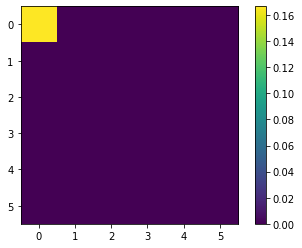

In [9]:
# Visualise the flow matrices at different times
plt.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
plt.imshow(fullflow_dir[0])
#plt.imshow(dynflow_dir[0])
plt.colorbar()
plt.show()

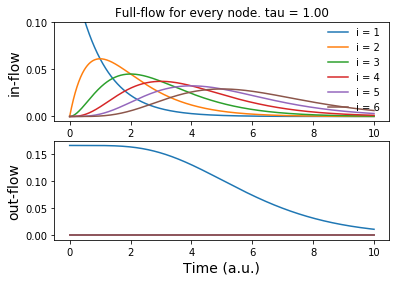

In [10]:
# Calculate the in-/out- full-flow for every node
# infullflow and outfullflow are two arrays of shape (N,nsteps)
infullflow_dir, outfullflow_dir = ndf.NodeEvolution(fullflow_dir)

# Plot a figure wit the input and output flows of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Full-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, infullflow_dir[i], label='i = %d' %(i+1))
plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outfullflow_dir[i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.show()

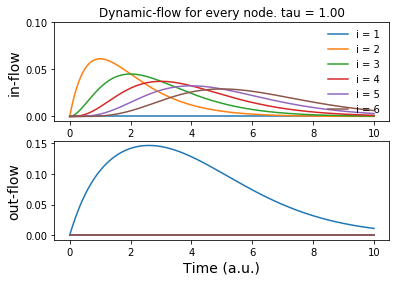

In [11]:
# Calculate the in-/out- dynamic-flow for every node
# inflow and outflow are two arrays of shape (N,nsteps)
inflow_dir, outflow_dir = ndf.NodeEvolution(dynflow_dir)

# Plot the input and output full-flow of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inflow_dir[i], label='i = %d' %(i+1))
plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outflow_dir[i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.show()

#### Dynamic communicability

The concept of flow is very general since it doesn't make any specific assumptions on which nodes are excited, and it even accepts the excitation of several nodes by correlated noise. That would be encoded by the extra-diagonal entries in the *sigma* matrix. For a generic and comparable method to study different networks, we name *dynamic communicability* to the special case of the flow in which every node is perturbed by independent Gaussian noise of the same variance. The idea is illustrated as follows:

<img src="Images/PathGraph_Directed2.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, the *sigma* matrix is represented as the unit matrix **1**. Thus, notice that function `netdynflow.DynCom()` does not require `sigma` as an explicit input.

In [12]:
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_dir = ndf.DynCom(dirnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)

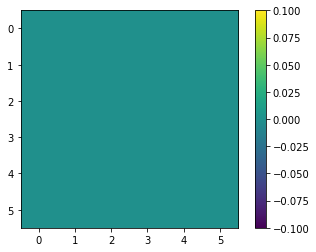

In [13]:
# Visualise the dynamic communicability matrices at different times
plt.figure()
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
plt.imshow(dyncom_dir[0])
plt.colorbar()
plt.show()

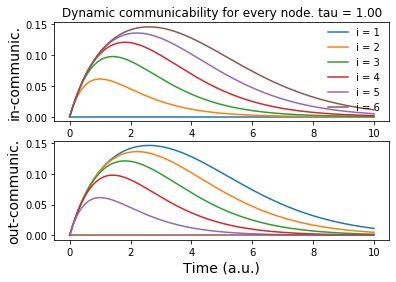

In [14]:
# Calculate the in-/out- dynamic communicability for every node
# indyncom and outdyncom are two arrays of shape (N,nsteps)
indyncom_dir, outdyncom_dir = ndf.NodeEvolution(dyncom_dir)

# Plot the input and output dynamic communicability of every node
plt.figure()
plt.subplot(2,1,1)
plt.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, indyncom_dir[i], label='i = %d' %(i+1))
plt.ylabel('in-communic.', fontsize=14)
plt.legend(frameon=False)

plt.subplot(2,1,2)
for i in range(N):
    plt.plot(tpoints, outdyncom_dir[i], label='i = %d' %(i+1))
plt.ylabel('out-communic.', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.show()

<br/>

We now repeat the study above but chains whose _**links are undirected**_ and follow the same perturbation "protocols" as illustrated below.

<img src="Images/PathGraph_Undirected1.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />
<img src="Images/PathGraph_Undirected2.pdf" style="float:center; width:500px; height:50px"  alt="Path Graph" />

In this case, the perturbations can diffuse in both directions. Also, the largest eigenvalue (λmax) of the path graph is finite, thus imposing a limitation to the largest τ time-constant. The condition **τmax < 1 / λmax** needs to be satisfied for the system to be convergent. Otherwise, if τmax > 1 / λmax, then leakage of "energy" at the nodes is insufficient to counterbalance the "energy" generated at the links, thus making the system diverge or explode.


In [15]:
# Create the undirected path graph of N = 6 nodes
N = 6
undnet = galib.models.PathGraph(N, directed=False)

# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(undnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:', evmax )
print( 'Largest possible tau:', maxtau)

Spectral radius: 1.8019377358
Largest possible tau: 0.554958132087


In [16]:
# Set the matrix of noisy inputs
sigma = zeros((N,N), np.float)
sigma[0,0] = 1.0
# Set a time-constant
tau = 0.45

# Define the temporal resolution
tfinal = 10
dt = 0.01
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
dynflow_und = ndf.DynFlow(undnet, tau, sigma, tmax=tfinal, timestep=dt, scalenorm=True)
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_und = ndf.DynCom(undnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)

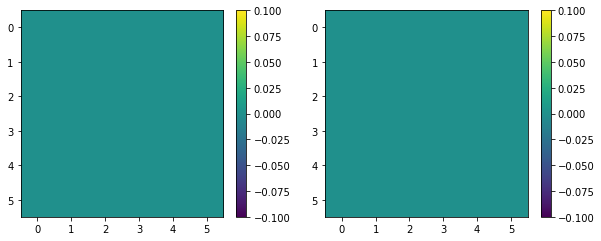

In [17]:
# Visualise the dynamic communicability matrices at different times
plt.figure(figsize=(10,3.8))
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
tidx = 0

# Plot the flow matrix
plt.subplot(1,2,1)
plt.imshow(dynflow_und[tidx], aspect='auto')
plt.colorbar()

# Plot the flow matrix
plt.subplot(1,2,2)
plt.imshow(dyncom_und[tidx], aspect='auto')
plt.colorbar()

#plt.tight_layout()
plt.show()

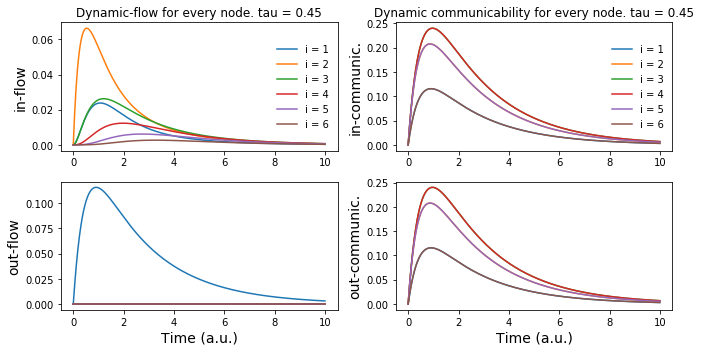

In [18]:
# Calculate the in-/out- dynamic flow and communicability for every node
inflow_und, outflow_und = ndf.NodeEvolution(dynflow_und)
indyncom_und, outdyncom_und = ndf.NodeEvolution(dyncom_und)


# Plot the input and output results for every node
plt.figure(figsize=(10,5))
# Plot the results for the in-/out-flow
plt.subplot(2,2,1)
plt.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inflow_und[i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,3)
for i in range(N):
    plt.plot(tpoints, outflow_und[i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

# Plot the results for the in-/out-dynamic communicability
plt.subplot(2,2,2)
plt.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, indyncom_und[i], label='i = %d' %(i+1))
plt.ylabel('in-communic.', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,4)
for i in range(N):
    plt.plot(tpoints, outdyncom_und[i], label='i = %d' %(i+1))
plt.ylabel('out-communic.', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.tight_layout()
plt.show()

### 1.2) Multi-path graphs
More intricate structures may lead to non-trivial propagation of the flow. A common characteristic in complex networks is that there is usually a variety of alternative paths within the network for the information to flow between two nodes. The simple examples below allow to explore how the presence of alternative paths influences both the flow and the dynamic communicability.

<img src="Images/MultiPathGraph_Directed.pdf" style="align:left; width:300px; height:180px"  alt="Multi-Path Digraph" />
<img src="Images/MultiPathGraph_Undirected.pdf" style="align:right; width:300px; height:180px"  alt="Multi-Path Digraph" />

We leave as an exercise to investigate the resulting behaviour of flow and dynamic communicability in these cases.

In [19]:
# Create a directed path graph of N = 6 nodes
N = 6
dircase = 'Directed'
if dircase=='Directed':
    mpgnet = array(((0,1,1,1,0,0),
                (0,0,0,0,1,0),
                (0,0,0,0,1,0),
                (0,0,0,0,1,0),
                (0,0,0,0,0,1),
                (0,0,0,0,0,0)), uint8)

elif dircase=='Undirected':
    mpgnet = array(((0,1,1,1,0,0),
                (1,0,0,0,1,0),
                (1,0,0,0,1,0),
                (1,0,0,0,1,0),
                (0,1,1,1,0,1),
                (0,0,0,0,1,0)), uint8)


# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(mpgnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
maxtau = 1./evmax

print( 'Spectral radius:', evmax )
print( 'Largest possible tau:', maxtau)

Spectral radius: 0.0
Largest possible tau: inf


/anaconda3/envs/neural_datascience/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [20]:
# Set the matrix of noisy inputs
sigma = zeros((N,N), np.float)
sigma[0,0] = 1.0
# Set a time-constant
if dircase=='Directed':
    tau = 1.0
elif dircase=='Undirected':
    tau = 0.3

# Define the temporal resolution
tfinal = 10
dt = 0.01
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic flow for a time span between 0 and tmax
dynflow_mpg = ndf.DynFlow(mpgnet, tau, sigma, tmax=tfinal, timestep=dt, scalenorm=True)
# Calculate the dynamic communicability for a time span between 0 and tmax
dyncom_mpg = ndf.DynCom(mpgnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)

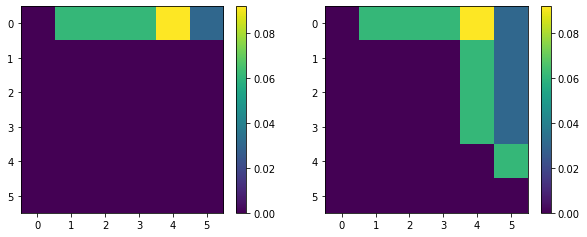

In [21]:
# Visualise the dynamic communicability matrices at different times
plt.figure(figsize=(10,3.8))
# Check for (temporal) indices: 0, 100, 200, 400, 600, 800
tidx = 100

# Plot the flow matrix
plt.subplot(1,2,1)
plt.imshow(dynflow_mpg[tidx], aspect='auto')
plt.colorbar()

# Plot the flow matrix
plt.subplot(1,2,2)
plt.imshow(dyncom_mpg[tidx], aspect='auto')
plt.colorbar()

#plt.tight_layout()
plt.show()

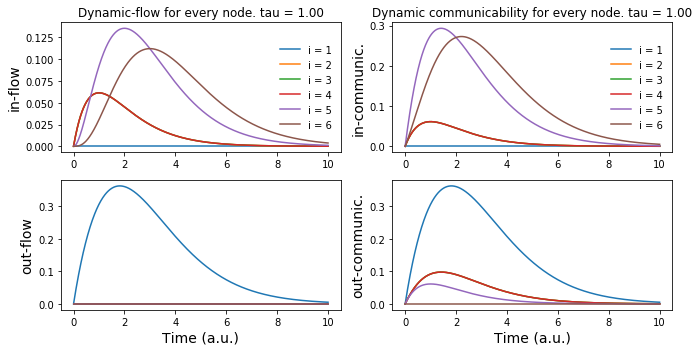

In [22]:
# Calculate the in-/out- dynamic flow and communicability for every node
inflow_mpg, outflow_mpg = ndf.NodeEvolution(dynflow_mpg)
indyncom_mpg, outdyncom_mpg = ndf.NodeEvolution(dyncom_mpg)


# Plot the input and output results for every node
plt.figure(figsize=(10,5))
# Plot the results for the in-/out-flow
plt.subplot(2,2,1)
plt.title('Dynamic-flow for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, inflow_mpg[i], label='i = %d' %(i+1))
#plt.ylim(-0.005,0.1)
plt.ylabel('in-flow', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,3)
for i in range(N):
    plt.plot(tpoints, outflow_mpg[i], label='i = %d' %(i+1))
plt.ylabel('out-flow', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

# Plot the results for the in-/out-dynamic communicability
plt.subplot(2,2,2)
plt.title('Dynamic communicability for every node. tau = %1.2f' %tau, fontsize=12)
for i in range(N):
    plt.plot(tpoints, indyncom_mpg[i], label='i = %d' %(i+1))
plt.ylabel('in-communic.', fontsize=14)
plt.legend(loc='center right', frameon=False)

plt.subplot(2,2,4)
for i in range(N):
    plt.plot(tpoints, outdyncom_mpg[i], label='i = %d' %(i+1))
plt.ylabel('out-communic.', fontsize=14)
plt.xlabel('Time (a.u.)', fontsize=14)

plt.tight_layout()
plt.show()

<br>

## PART 2: Common graph models

In this section we will study common network models: random graphs, scale-free graphs and ring lattices. While the present formalism is well suited to characterise weighted networks (where the links of weights represent coupling strength, a flow capacity, etc.) application to such binary graph models helps gain further intuition on its results. We will

1. Generate some random, scale-free and regular networks.
2. Elucidate on the choice of a time-constant.
3. Describe the total communicability and the diversity of the networks
4. Define a new metric of distance for networks.

Before starting, we need to import from the *GAlib* package the functions needed to create the network models.

In [23]:
# Set the size, density and number of links for the networks
N = 100
dens = 0.1
L = int( round(0.5*dens*N*(N-1)))

# Generate the networks. They all have same number of links
randnet = galib.models.RandomGraph(N,L, directed=False)
sfnet = galib.models.ScaleFreeGraph(N,L, exponent=3.0, directed=False)
ringnet = galib.models.Lattice1D_FixLinks(N,L)

# Calculate their spectral radii
# For the random graph 
evs = numpy.linalg.eigvals(randnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_rand = evsnorms.max()
maxtau_rand = 1./evmax_rand

# For the scale-free graph
evs = numpy.linalg.eigvals(sfnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_sf = evsnorms.max()
maxtau_sf = 1./evmax_sf

# For the ring lattice 
evs = numpy.linalg.eigvals(ringnet)
evsnorms = zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax_ring = evsnorms.max()
maxtau_ring = 1./evmax_ring


print( 'RANDOM:     λmax = %3.5f  τmax = %3.5f' %(evmax_rand, maxtau_rand) )
print( 'SCALE-FREE: λmax = %3.5f  τmax = %3.5f' %(evmax_sf, maxtau_sf) )
print( 'RING LATT:  λmax = %3.5f  τmax = %3.5f' %(evmax_ring, maxtau_ring) )

RANDOM:     λmax = 10.55215  τmax = 0.09477
SCALE-FREE: λmax = 13.40223  τmax = 0.07461
RING LATT:  λmax = 9.95968  τmax = 0.10040


In [24]:
# Set a time-constant
tau = 0.05

# Define the temporal resolution
tfinal = 1.5
dt = 0.001
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic communicability for the three models
dyncom_rand = ndf.DynCom(randnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)
dyncom_sf = ndf.DynCom(sfnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)
dyncom_ring = ndf.DynCom(ringnet, tau, tmax=tfinal, timestep=dt, scalenorm=True)

#### Global network metrics
In this case, instead of studying the node-wise in-/out-communicability as in the examples above, we will focus on describing some global network metrics. We will characterise the:

- *Total communicability:* is the sum of all the communicability values in the dynamic communicability matrix, calculated for all time-points. It quantifies the total level of interactions in the network at integration time *t = t'* after the stimulus onset.
- *Diversity* is the metric that characterises how homogeneous are the pair-wise interactions. At early times after stimulus direct links play a more relevant role but as time passes indirect paths become more relevant. In this proces, communicability tends to homogeneise across pairs.

/anaconda3/envs/neural_datascience/lib/python3.6/site-packages/netdynflow/metrics.py:126: RuntimeWarning: invalid value encountered in double_scalars
  diversity[t] = dyntensor[t].std() / dyntensor[t].mean()


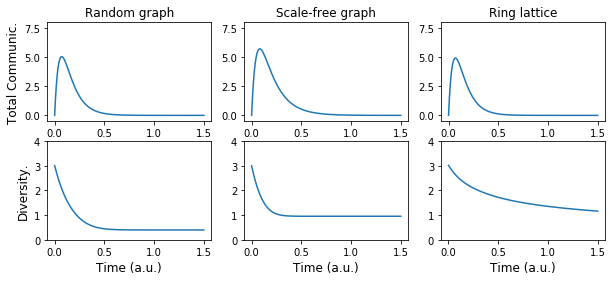

In [25]:
# Calculate the total communicability over time for the three networks
# Results 'totcom' are 1D numpy arrays of length nsteps
totcom_rand = ndf.TotalEvolution(dyncom_rand)
totcom_sf = ndf.TotalEvolution(dyncom_sf)
totcom_ring = ndf.TotalEvolution(dyncom_ring)

# Calculate the diversity over time of the three networks
# Results 'divers' are 1D numpy arrays of length nsteps
divers_rand = ndf.Diversity(dyncom_rand)
divers_sf = ndf.Diversity(dyncom_sf)
divers_ring = ndf.Diversity(dyncom_ring)

# Plot the results
plt.figure(figsize=(10,4))
# For the random graph
plt.subplot(2,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(tpoints,totcom_rand)
plt.ylim(-0.5,8)
plt.ylabel('Total Communic.', fontsize=12)

plt.subplot(2,3,4)
plt.plot(tpoints,divers_rand)
plt.ylim(0,4)
plt.ylabel('Diversity.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the scale-free graph
plt.subplot(2,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(tpoints,totcom_sf)
plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)

plt.subplot(2,3,5)
plt.plot(tpoints,divers_sf)
plt.ylim(0,4)
#plt.ylabel('Diversity.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)

# For the ring lattice
plt.subplot(2,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(tpoints,totcom_ring)
plt.ylim(-0.5,8)
#plt.ylabel('Total Communic.', fontsize=12)

plt.subplot(2,3,6)
plt.plot(tpoints,divers_ring)
plt.ylim(0,4)
#plt.ylabel('Diversity.', fontsize=12)
plt.xlabel('Time (a.u.)', fontsize=12)


#plt.tight_layout()
plt.show()


As an exercise, try changing the τ time-constant considering the τmax values returned by the calculation of the spectral radius of each network.

#### A metric for graph distance based on dynamic communicability
The classical graph distance quantifies the minimum number of "jumps" required in order to travel from one node to another. This definition is only valid for binary graphs where the only relevant information carried by the links is the presence or the absence of a link. All-to-all pairwise graph distance can be calculated following the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm). Despite a weighted version of the algorithm exists, this **can only be applied when the links of the weights represent the euclidean distance** between the two nodes, which are embedded in a geometric space, i.e., nodes represent the cities in a country and their link weights are the physical distance between them. For any other weighted networks the weighted Floyd-Warshall algorithm is not to be applied.

Now, we shall notice that in the usual graph distance, the number of jumps, represent the first time passage of signals in a diffusion process. But in that case both the signals and time are discrete. Considering this dynamic perspective, following the fact that our formalism characterises a continuous diffusion process we will define the distance between two nodes as the time the pair-wise communicability takes to reach its peak. This **"time-to-peak" distance** captures the optimal time at which one node i influences most over another node j. Notice that this optimal time is not necessarily symmetric. It will depend on the specific path structure and the distribution of link weights.

Let us now compute the time-to-peak (TTP) distance and compare it to the usual graph distance in the three networks.

In [26]:
# Calculate the usual graph distance matrices for the three networks
dij_rand = galib.FloydWarshall(randnet)
dij_sf = galib.FloydWarshall(sfnet)
dij_ring = galib.FloydWarshall(ringnet)

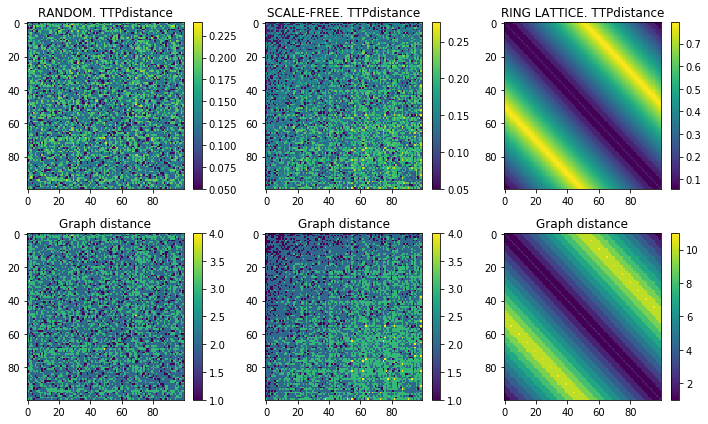

In [27]:
# Calculate now the TTPdistance for the three networks
ttpdist_rand = tpoints[dyncom_rand.argmax(axis=0)]
ttpdist_sf = tpoints[dyncom_sf.argmax(axis=0)]
ttpdist_ring = tpoints[dyncom_ring.argmax(axis=0)]

# Compare to the usual graph distances
plt.figure(figsize=(10,6))
# Random graphs
plt.subplot(2,3,1)
plt.title('RANDOM. TTPdistance', fontsize=12)
plt.imshow(ttpdist_rand, aspect='auto')
plt.colorbar()

plt.subplot(2,3,4)
plt.title('Graph distance', fontsize=12)
plt.imshow(dij_rand, aspect='auto')
plt.colorbar()

# Scale-free graphs
plt.subplot(2,3,2)
plt.title('SCALE-FREE. TTPdistance', fontsize=12)
plt.imshow(ttpdist_sf, aspect='auto')
plt.colorbar()

plt.subplot(2,3,5)
plt.title('Graph distance', fontsize=12)
plt.imshow(dij_sf, aspect='auto')
plt.colorbar()

# Ring-lattices
plt.subplot(2,3,3)
plt.title('RING LATTICE. TTPdistance', fontsize=12)
plt.imshow(ttpdist_ring, aspect='auto')
plt.colorbar()

plt.subplot(2,3,6)
plt.title('Graph distance', fontsize=12)
plt.imshow(dij_ring, aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

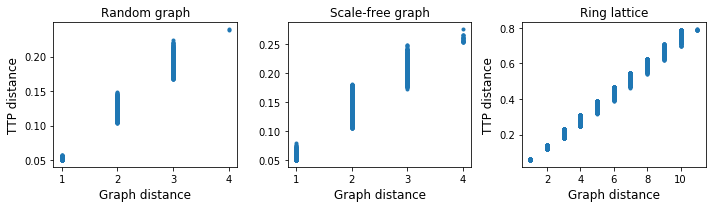

In [28]:
# Compare the pair-wise distances
# Consider only the upper triangular elements
triuidx = np.triu_indices(N,k=1)

plt.figure(figsize=(10,3))
# Relation for random graphs
plt.subplot(1,3,1)
plt.title('Random graph', fontsize=12)
plt.plot(dij_rand[triuidx], ttpdist_rand[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
plt.ylabel('TTP distance', fontsize=12)

# Relation for scale-free graphs
plt.subplot(1,3,2)
plt.title('Scale-free graph', fontsize=12)
plt.plot(dij_sf[triuidx], ttpdist_sf[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
#plt.ylabel('TTP distance', fontsize=12)

# Relation for ring-lattices graphs
plt.subplot(1,3,3)
plt.title('Ring lattice', fontsize=12)
plt.plot(dij_ring[triuidx], ttpdist_ring[triuidx], '.')
plt.xlabel('Graph distance', fontsize=12)
plt.ylabel('TTP distance', fontsize=12)

plt.tight_layout()
plt.show()


<br>

## PART 3: Application to neuroimaging data

The Block-2 of the morning session dealed with the identification of whole-brain effective connectivity (EC), by taking the multivariate Ornstein Uhlenbeck (MOU) model as the generative model for the dynamics observed in fMRI. In the following, we will apply the tools here presented to study the spatio-temporal network properties of brain connectivity, taking the weighted EC matrix as the underlying (or generating) connectivity.

4. Application to neuroimage data
    1. EC of movie data (Do Not estimate, use the results from Matt in the morning)
    2. Total communicability + divergence
    3. Input/output node-wise communicability. Correlation with SC degree/rich-club?
    4. Node-wise differences between rest and movie.
    5. Correlations between degree (intensity) and in-/out-communicabilities

First of all, we will need to read the EC matrices derived in Block-2 of the morning session. The dataset consists of fMRI recording on 22 healthy subjects. There are two conditions: rest and movie watching. For rest, there are two scanning sessions per subject, and for movie condition, there are three recording sessions. For the illustrative purposes of this tutorial, we will work with only two EC matrices after averaging all ECs for rest and all ECs for movie viewing.

**NOTE**: In this case, we do not need to make a choice for the value of the time-constant τ, since τ is given by the EC estimation process.

In [29]:
# Load the EC matrices calculated in the morning
datapath = '../model_param/'
ECmats = np.load(datapath + 'J_mod.npy')
nsubs, nsessions, N,N = np.shape(ECmats)

# Get the average EC matrices for the two conditions
ecrest = ECmats[:,:2].mean(axis=(0,1))
ecmovie = ECmats[:,2:].mean(axis=(0,1))

# Extract the estimated time-constant, 
# which is in the diagonals of the J matrices
tau_rest = np.mean( -1 / ecrest.diagonal() )
tau_movie = np.mean( -1 / ecmovie.diagonal() )

# Print out the estimated time-constants ...
print( 'τ for rest:  %2.5f' %tau_rest )
print( 'τ for movie: %2.5f' %tau_movie )


τ for rest:  2.21393
τ for movie: 2.32038


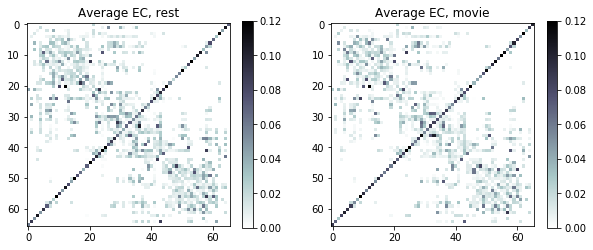

In [30]:
# Remove the diagonal entries from the J matrices to get the ECs ...
ecrest[diag_indices(N)] = 0.0
ecmovie[diag_indices(N)] = 0.0

# ... and visualise them
plt.figure(figsize=(10,3.8))

plt.subplot(1,2,1)
plt.title('Average EC, rest', fontsize=12)
plt.imshow(ecrest, cmap='bone_r')
plt.clim(0,0.12)
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Average EC, movie', fontsize=12)
plt.imshow(ecmovie, cmap='bone_r')
plt.colorbar()
plt.clim(0,0.12)

plt.show()

Once we have the two average EC matrices, we now start the network analysis using the dynamic communicability. 

In [31]:
# Define the temporal resolution
tfinal = 100
dt = 0.1
tpoints = arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the dynamic communicability for the three models
dyncom_rest = ndf.DynCom(ecrest, tau_rest, tmax=tfinal, timestep=dt, scalenorm=True)
dyncom_movie = ndf.DynCom(ecmovie, tau_movie, tmax=tfinal, timestep=dt, scalenorm=True)

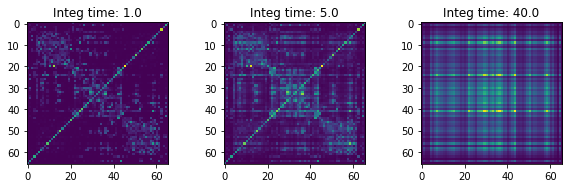

In [32]:
# Visualise the temporal evolution of dynamic communicability
tearly = 10
tmiddle = 50
tlate = 400

plt.figure(figsize=(10,2.6))
plt.subplot(1,3,1)
plt.title('Integ time: %2.1f' %tpoints[tearly], fontsize=12)
plt.imshow(dyncom_rest[tearly])
#plt.colorbar()

plt.subplot(1,3,2)
plt.title('Integ time: %2.1f' %tpoints[tmiddle], fontsize=12)
plt.imshow(dyncom_rest[tmiddle])
#plt.colorbar()

plt.subplot(1,3,3)
plt.title('Integ time: %2.1f' %tpoints[tlate], fontsize=12)
plt.imshow(dyncom_rest[tlate])
#plt.colorbar()

#plt.tight_layout()
plt.show()


/anaconda3/envs/neural_datascience/lib/python3.6/site-packages/netdynflow/metrics.py:126: RuntimeWarning: invalid value encountered in double_scalars
  diversity[t] = dyntensor[t].std() / dyntensor[t].mean()


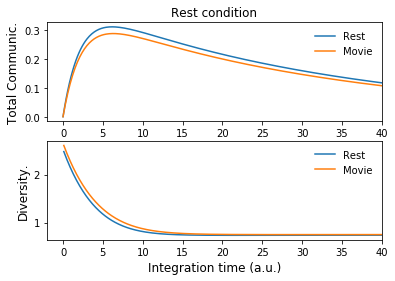

In [33]:
# Calculate the total communicability over time for the three networks
# Results 'totcom' are 1D numpy arrays of length nsteps
totcom_rest = ndf.TotalEvolution(dyncom_rest)
totcom_movie = ndf.TotalEvolution(dyncom_movie)

# Calculate the diversity over time of the three networks
# Results 'divers' are 1D numpy arrays of length nsteps
divers_rest = ndf.Diversity(dyncom_rest)
divers_movie = ndf.Diversity(dyncom_movie)

# Plot the results
plt.figure()
# For the RESTING condition
plt.subplot(2,1,1)
plt.title('Rest condition', fontsize=12)
plt.plot(tpoints,totcom_rest, label='Rest')
plt.plot(tpoints,totcom_movie, label='Movie')
plt.xlim(-2,40)
#plt.ylim(-0.5,8)
plt.ylabel('Total Communic.', fontsize=12)
plt.legend(loc='upper right', frameon=False)

plt.subplot(2,1,2)
plt.plot(tpoints,divers_rest, label='Rest')
plt.plot(tpoints,divers_movie, label='Movie')
plt.xlim(-2,40)
#plt.ylim(0,4)
plt.ylabel('Diversity.', fontsize=12)
plt.xlabel('Integration time (a.u.)', fontsize=12)
plt.legend(loc='upper right', frameon=False)

#plt.tight_layout()
plt.show()

<br/>

Now, let's study the **ROI-wise properties** in rest and movie viewing conditions

In [34]:
# Calculate the in-/out- dynamic communicability for every node
incom_rest, outcom_rest = ndf.NodeEvolution(dyncom_rest)
incom_movie, outcom_movie = ndf.NodeEvolution(dyncom_movie)

# ... let's get the ROI-wise differences across conditions
incom_diff = incom_movie - incom_rest
outcom_diff = outcom_movie - outcom_rest

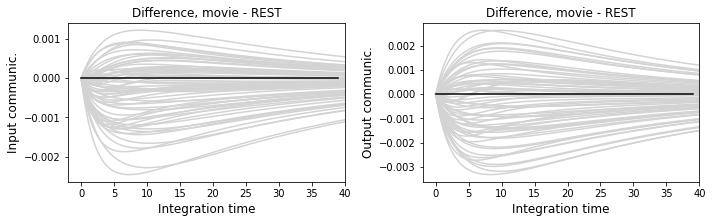

In [35]:
# Visualise the results for the differences
plt.figure(figsize=(10,3.2))
plt.subplot(1,2,1)
plt.title('Difference, movie - REST', fontsize=12)
plt.plot(tpoints, incom_diff.T, color='lightgray')
plt.plot(arange(0,40), zeros(40), color='black')
plt.xlim(-2,40)
plt.xlabel('Integration time', fontsize=12)
plt.ylabel('Input communic.', fontsize=12)

plt.subplot(1,2,2)
plt.title('Difference, movie - REST', fontsize=12)
plt.plot(tpoints, outcom_diff.T, color='lightgray')
plt.plot(arange(0,40), zeros(40), color='black')
plt.xlim(-2,40)
plt.xlabel('Integration time', fontsize=12)
plt.ylabel('Output communic.', fontsize=12)


plt.tight_layout()
plt.show()

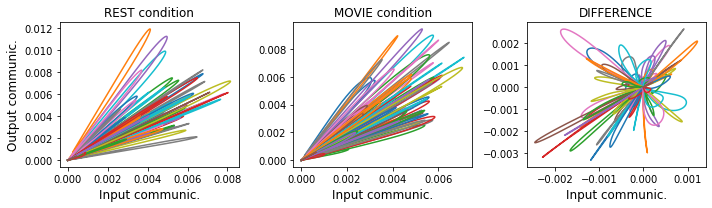

In [36]:
# Visualise the trajectories
plt.figure(figsize=(10,3))
# RESTING condition
plt.subplot(1,3,1)
plt.title('REST condition', fontsize=12)
plt.plot(incom_rest.T, outcom_rest.T)
#plt.xlim(0,0.012)
#plt.ylim(0,0.012)
plt.xlabel('Input communic.', fontsize=12)
plt.ylabel('Output communic.', fontsize=12)

# MOVIE condition
plt.subplot(1,3,2)
plt.title('MOVIE condition', fontsize=12)
plt.plot(incom_movie.T, outcom_movie.T)
#plt.xlim(0,0.012)
#plt.ylim(0,0.012)
plt.xlabel('Input communic.', fontsize=12)
#plt.ylabel('Output communic.', fontsize=12)


# DIFFERENCE
plt.subplot(1,3,3)
plt.title('DIFFERENCE', fontsize=12)
plt.plot(incom_diff.T, outcom_diff.T)
#plt.xlim(0,0.012)
#plt.ylim(0,0.012)
plt.xlabel('Input communic.', fontsize=12)
#plt.ylabel('Output communic.', fontsize=12)


plt.tight_layout()
plt.show()

Finally, we compare other usual ROI-wise properties

In [37]:
# Calculate the degree of all ROIs
deg_rest = galib.Degree(ecrest, directed=False)
deg_movie = galib.Degree(ecmovie, directed=False)

# Calculate the input / output EC strengths of the ROIS
inintens_rest, outintens_rest = galib.Intensity(ecrest, directed=True)
inintens_movie, outintens_movie = galib.Intensity(ecmovie, directed=True)

# Calculate the total in-/out- nodewise communicabilities
totincom_rest = incom_rest.sum(axis=1)
totoutcom_rest = outcom_rest.sum(axis=1)
totincom_movie = incom_movie.sum(axis=1)
totoutcom_movie = outcom_movie.sum(axis=1)
